In [ ]:
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.1 MB/s eta 0:00:00
Reason for being yanked: deprecated, use 4.8.0.76
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.10.0.82
    Uninstalling opencv-python-headless-4.10.0.82:
      Successfully uninstalled opencv-python-headless-4.10.0.82
  Attempting uninstall: idna
    Found existing installation: idna 3.7
    Uninstalling idna-3.7:
      Successfully uninstalled idna-3.7
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cy

In [ ]:
!pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 34.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

In [ ]:
!pip install pytesseract

In [ ]:
import easyocr
import cv2
import pytesseract
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
from PIL import Image

In [ ]:
!apt-get install tesseract-ocr-ind

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-ind tesseract-ocr-osd
0 upgraded, 4 newly installed, 0 to remove and 45 not upgraded.
Need to get 5,353 kB of archives.
After this operation, 16.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-ind all 1:4.00~git30-7274cfa-1.1 [537 kB]
Fetched 5,353 kB in 3s (2,027 kB/s)
Selecting previously u

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="f77FoHccQ1RtNOK1tFRo")
project = rf.workspace("jakob-awn1e").project("receipt-or-invoice")
version = project.version(2)
dataset = version.download("folder")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Receipt-or-Invoice-2 in folder:: 100%|██████████| 4325/4325 [00:00<00:00, 4453.11it/s]


In [ ]:
# Preprocessing
def preprocess_images(image_path):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image) / 255.0  # Normalization
    return image

def preprocess_for_ocr(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)  # Apply thresholding
    denoised = cv2.fastNlMeansDenoising(thresh, None, 30, 7, 21)  # Denoise the image
    return denoised

In [ ]:
def label_data(data_path):
    images = []
    labels = []
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):  # Ensure processing only image files
                file_path = os.path.join(root, file)
                label = os.path.basename(os.path.dirname(file_path))  # Correct label extraction
                image = preprocess_images(file_path)
                images.append(image)
                labels.append(label)
    return np.array(images), np.array(labels)

In [ ]:
# Load dataset
train_path = "/content/Receipt-or-Invoice-2/train"
val_path = "/content/Receipt-or-Invoice-2/valid"
test_path = "/content/Receipt-or-Invoice-2/test"

In [ ]:
X_train, y_train = label_data(train_path)
X_val, y_val = label_data(val_path)
X_test, y_test = label_data(test_path)

In [ ]:
# Combining labels from all three datasets
all_labels = np.concatenate((y_train, y_val, y_test))

# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

# Re-encode labels for each dataset
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [ ]:
# Build CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=32)

# Evaluate the model
_, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

Epoch 1/15
118/118 [==============================] - 13s 74ms/step - loss: 0.4452 - accuracy: 0.8169 - val_loss: 0.2474 - val_accuracy: 0.9194
Epoch 2/15
118/118 [==============================] - 6s 54ms/step - loss: 0.1976 - accuracy: 0.9308 - val_loss: 0.2152 - val_accuracy: 0.9250
Epoch 3/15
118/118 [==============================] - 7s 58ms/step - loss: 0.1499 - accuracy: 0.9520 - val_loss: 0.2054 - val_accuracy: 0.9306
Epoch 4/15
118/118 [==============================] - 7s 57ms/step - loss: 0.1119 - accuracy: 0.9658 - val_loss: 0.2053 - val_accuracy: 0.9278
Epoch 5/15
118/118 [==============================] - 7s 58ms/step - loss: 0.0940 - accuracy: 0.9714 - val_loss: 0.2919 - val_accuracy: 0.8861
Epoch 6/15
118/118 [==============================] - 7s 56ms/step - loss: 0.0761 - accuracy: 0.9764 - val_loss: 0.1753 - val_accuracy: 0.9389
Epoch 7/15
118/118 [==============================] - 7s 56ms/step - loss: 0.0692 - accuracy: 0.9783 - val_loss: 0.2209 - val_accuracy: 0.925

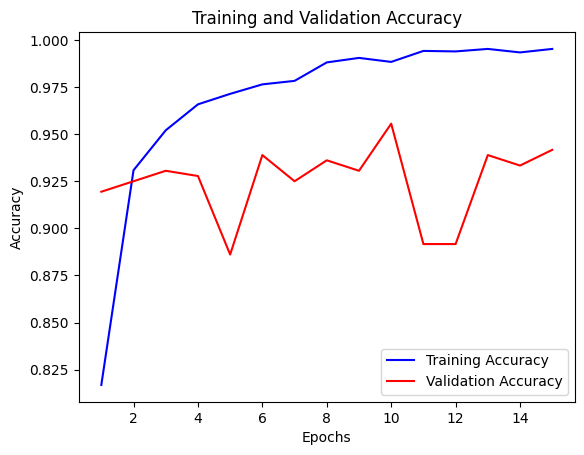

In [ ]:
# Plot training and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Perform text recognition using OCR
def perform_ocr(image_path):
    reader = easyocr.Reader(['en', 'id'])
    result = reader.readtext(image_path)
    return result

In [ ]:
# Integrate everything
def integrate_ocr_with_model(image_path):
    # Predict class using the CNN model
    image = preprocess_images(image_path)
    prediction = np.argmax(model.predict(np.array([image])))

    # Perform OCR on the image
    ocr_result = perform_ocr(image_path)

    return label_encoder.classes_[prediction], ocr_result

In [ ]:
# Example usage:
image_path = "/content/Receipt.jpg"
predicted_class, ocr_result = integrate_ocr_with_model(image_path)
print("Predicted Class:", predicted_class)
print("OCR Result:")
for detection in ocr_result:
    print(f"Text: {detection[1]}, Confidence: {detection[2]}")

1/1 [==============================] - 0s 402ms/step


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Predicted Class: receipt
OCR Result:
Text: Berqhote ], Confidence: 0.8967519824164157
Text: Grosse, Confidence: 0.9994529007405955
Text: Sche, Confidence: 0.9430770206822389
Text: 3818 Grinde IwaId, Confidence: 0.6536418927028312
Text: Fami lie R. Müller, Confidence: 0.2759040316249924
Text: Rech. Nr, Confidence: 0.9790536126821262
Text: 4572, Confidence: 0.9999497532844543
Text: 30.07.2007/13.29; 17, Confidence: 0.4803789688803072
Text: Bar, Confidence: 0.9997860933634213
Text: Tisch, Confidence: 0.9999338395310541
Text: 7/01, Confidence: 0.9996415972709656
Text: 2xLatte Macchiato, Confidence: 0.8769158285422676
Text: à, Confidence: 0.9996517007893004
Text: 4.50, Confidence: 0.9664233922958374
Text: CHF, Confidence: 0.996786334616584
Text: 9.00, Confidence: 0.8152823448181152
Text: IxG Ioki, Confidence: 0.4614249274482178
Text: à, Confidence: 0.9995884126829289
Text: 5.00, Confidence: 0.5018001198768616
Text: CHF, Confidence: 0.9980319187427925
Text: 5.00, Confidence: 0.92372399568557

In [ ]:
# Example usage:
image_path = "/content/invoice.png"
predicted_class, ocr_result = integrate_ocr_with_model(image_path)
print("Predicted Class:", predicted_class)
print("OCR Result:")
for detection in ocr_result:
    print(f"Text: {detection[1]}, Confidence: {detection[2]}")

1/1 [==============================] - 0s 19ms/step
Predicted Class: invoice
OCR Result:
Text: PT. Bintang Makmur, Confidence: 0.9931868397582068
Text: JL Pajajaran No 200 Ujungberung Bandung, Confidence: 0.7356129336232567
Text: INVOICE, Confidence: 0.9993074884917803
Text: NO: 4262782444, Confidence: 0.7918344681619945
Text: Customor:, Confidence: 0.7758278692859658
Text: Tanggal:, Confidence: 0.9901924041302075
Text: 02-Doc-2010, Confidence: 0.7080820720910378
Text: Cllacap, Toko Buku, Confidence: 0.8748850811984009
Text: Alamat, Confidence: 0.9798944370809476
Text: JL Cihampclas No 201, Confidence: 0.991067538656556
Text: No Order:, Confidence: 0.6526089323171935
Text: 7347324, Confidence: 0.6088045512535541
Text: Kota, Confidence: 0.9907302856445312
Text: Bandung, Confidence: 0.9994108252954842
Text: Telepon, Confidence: 0.6790038079093476
Text: 022-876351545, Confidence: 0.6568971449118448
Text: Nama Barang, Confidence: 0.9560706865619055
Text: Satuan, Confidence: 0.9954744399099

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)